# Mall customer segmentation using K-Means clustering method
We are going to try to segment customer data we've got from mall. Dataset is small and easy to work with, has no missing values and almost no outliers (will ignore it).

Dataset overview:
- **Customer ID**: Id of customer, this field will be dropped as it's not useful
- **Gender**: customer gender - female / male
- **Age**: age of customer, we've got customers with age from 18 to 70 years
- **Annual Income**: income of customer, will be renamed to income only, values from 13 to 137
- **Spending Score**: Score assigned by the mall based on customer behavior and spending nature, values from 1 to 99

# Import libraries
Basic set of libraries is used in this simple demo, including numpy, pandas, seaborn, matplotlib and 2 functions from sklearn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Load data and rename columns
Why to rename columns? It's not needed, but it is much simpler to work with dataset that has simple naming convention. Customer ID column is dropped as well.

In [3]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop('CustomerID', axis=1)
df.columns = ['Gender', 'Age', 'Income', 'Score']
df.head(5)

,Gender,Age,Income,Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Data check
It is basic to check if dataset fields are stored in proper format (sometimes number is stored as object) and quickly check if we have to deal with missing values as well.

In [4]:
# basic information about columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  200 non-null    object
 1   Age     200 non-null    int64 
 2   Income  200 non-null    int64 
 3   Score   200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [5]:
# count null values in each column
df.isnull().sum()

Gender    0
Age       0
Income    0
Score     0
dtype: int64

Looks great! Fields are stored probably and no null values. This will not happen in real world problem :)

# Exploratory data analysis
This dataset contains task to find hidden patterns and some cool stuff about the data, so let's just try to find something based on different visualizations!

## Distribution difference based on gender
Is there any significant difference based on gender on features Age, Income or Score? You will find there is nothing significant except slightly more females in age around 28 and slightly more females with score around 50.

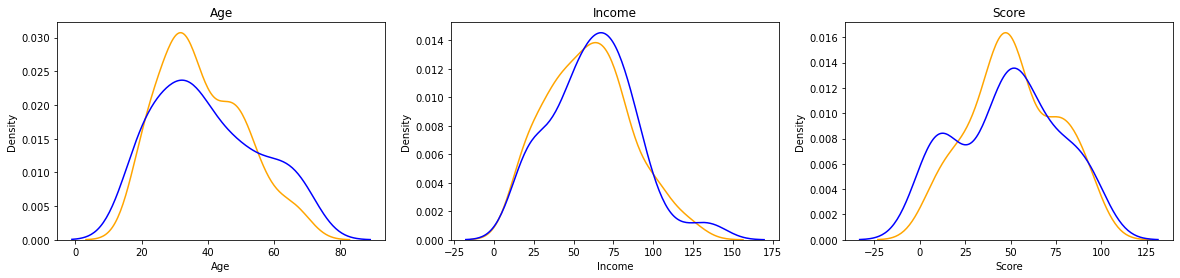

In [6]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
sns.distplot(df.Age[df['Gender']=='Female'], color='orange', hist=False, kde=True, label='Female')
sns.distplot(df.Age[df['Gender']=='Male'], color='blue', hist=False, kde=True, label='Male')
plt.title('Age')

plt.subplot(1,3,2)
sns.distplot(df.Income[df['Gender']=='Female'], color='orange', hist=False, kde=True, label='Female')
sns.distplot(df.Income[df['Gender']=='Male'], color='blue', hist=False, kde=True, label='Male')
plt.title('Income')

plt.subplot(1,3,3)
sns.distplot(df.Score[df['Gender']=='Female'], color='orange', hist=False, kde=True, label='Female')
sns.distplot(df.Score[df['Gender']=='Male'], color='blue', hist=False, kde=True, label='Male')
plt.title('Score')

plt.show()


## Differences in Age, Income and Score by gender
Boxplot visualization will be used to see also quartiles, distribution, median and outliers. You will find there is one outlier by Income/Male, but we will not handle it.

There is no significant difference or finding except that Female seems to have higher bound for lower score (first quartile)... but we already know they like to go to shopping malls more likely than Males ;)

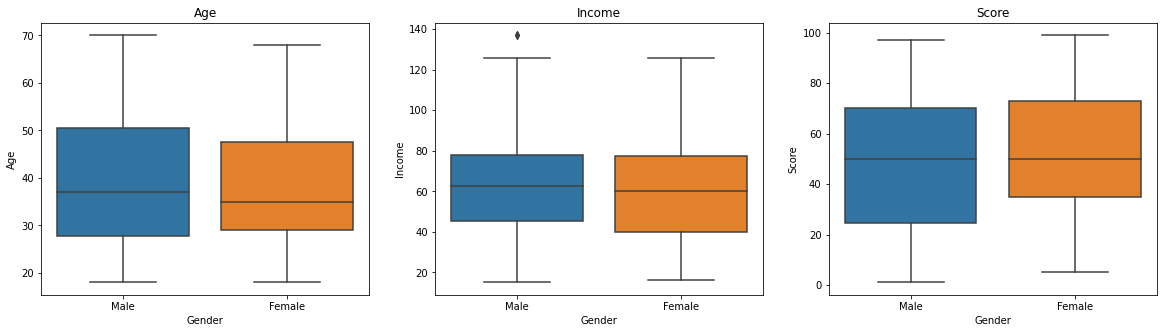

In [7]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.boxplot(x=df.Gender, y=df.Age)
plt.title('Age')

plt.subplot(1,3,2)
sns.boxplot(x=df.Gender, y=df.Income)
plt.title('Income')

plt.subplot(1,3,3)
sns.boxplot(x=df.Gender, y=df.Score)
plt.title('Score')

plt.show()

## Relation between variables
Investigate if there is significant relation between variables, i.e. income increase with age or score decrease with age.

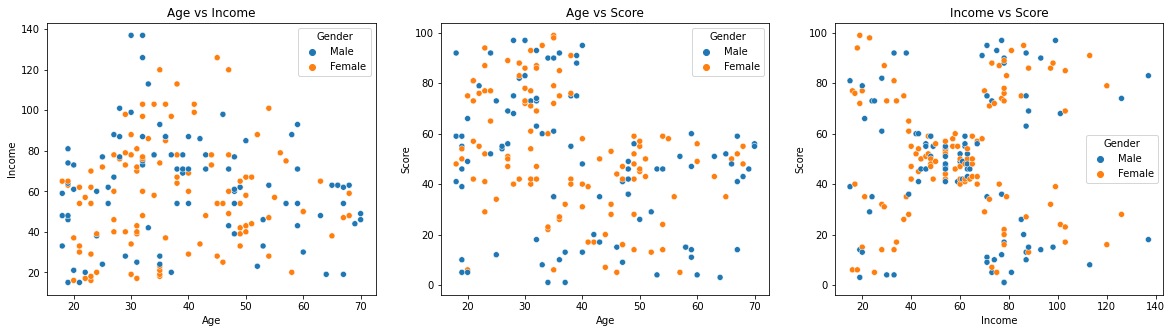

In [8]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.scatterplot(x=df.Age, y=df.Income, hue=df.Gender)
plt.title('Age vs Income')

plt.subplot(1,3,2)
sns.scatterplot(x=df.Age, y=df.Score, hue=df.Gender)
plt.title('Age vs Score')

plt.subplot(1,3,3)
sns.scatterplot(x=df.Income, y=df.Score, hue=df.Gender)
plt.title('Income vs Score')

plt.show()

### Have you found something?
I did actually... you can see there seems to be 2 groups of customers by age vs score (top left quarter vs bottom right quarter), where diagonal is delimiting them.

What is more important is actually chart Income vs Score where we can see 5 different groups of customers (corners & center). What does it mean? We've probably found ideal way to cluster our customers based on income and score!

## Income & Score by Age
Last, check if there is significant difference (increasing/decreasing trend) when looking on Income or Score by Age. What is bit weird for me is that 18 years people has almost same score as 60 years old.

You may notice that income seems to be highest for age group 25-50 comparing to others and similary, score is higer for group of people in age 20-40 comparing to others.

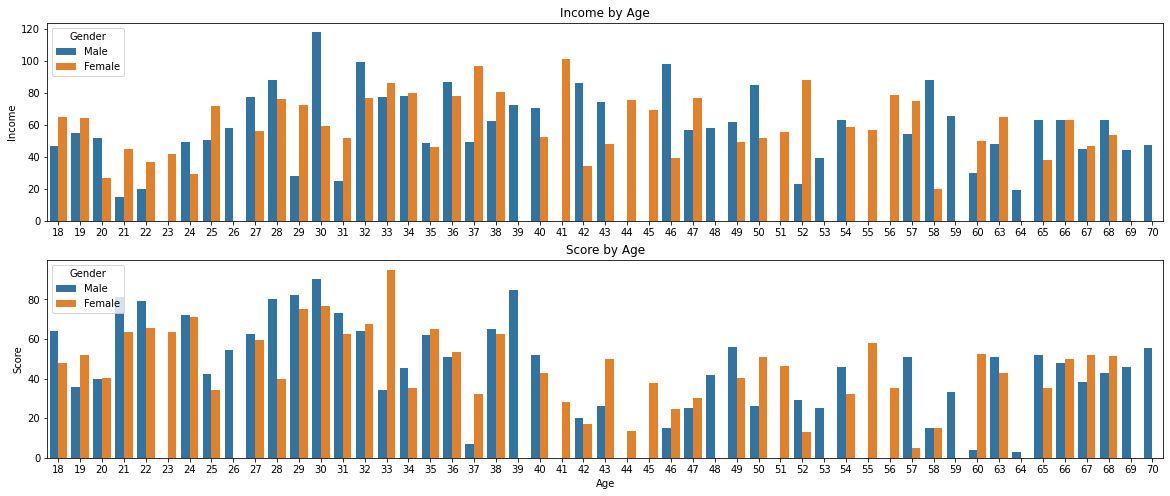

In [9]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
sns.barplot(x=df.Age, y=df.Income, hue=df.Gender, ci=0)
plt.title('Income by Age')
plt.xlabel('')

plt.subplot(2,1,2)
sns.barplot(x=df.Age, y=df.Score, hue=df.Gender, ci=0)
plt.title('Score by Age')

plt.show()

# Data preparation
Gender column will be encoded into 0/1 values, new dataframe will be created as well having age, income and score normalized. This is done just to compare if there will be any difference in elbow method, however all columns except age has pretty much same values so we should not see anything extreme here (values in range 0-100).

In [10]:
# one hot encoding, keeping just male column, so 1 = male, 0 = female
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)       #Thanks to Evan for suggestion
df = df.rename(columns={'Gender_Male':'Gender'})

In [11]:
# create new dataframe with transformed values
df_t = df.copy()

ss = StandardScaler()
df_t['Age'] = ss.fit_transform(df['Age'].values.reshape(-1,1))
df_t['Income'] = ss.fit_transform(df['Income'].values.reshape(-1,1))
df_t['Score'] = ss.fit_transform(df['Score'].values.reshape(-1,1))

## Transformed vs Original
We have found possible clustering on chart income vs score and age vs score. Just quickly check how it looks like on normalized and raw data. Notice just axis ticks has changed and nothing else.

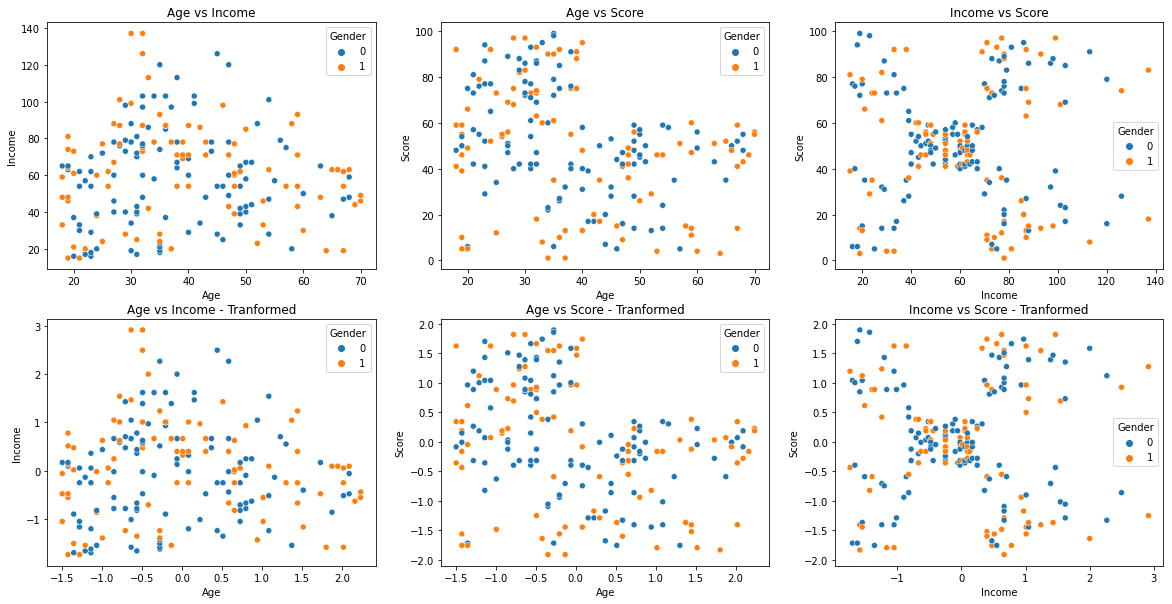

In [12]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
sns.scatterplot(x=df.Age, y=df.Income, hue=df.Gender)
plt.title('Age vs Income')

plt.subplot(2,3,2)
sns.scatterplot(x=df.Age, y=df.Score, hue=df.Gender)
plt.title('Age vs Score')

plt.subplot(2,3,3)
sns.scatterplot(x=df.Income, y=df.Score, hue=df.Gender)
plt.title('Income vs Score')

plt.subplot(2,3,4)
sns.scatterplot(x=df_t.Age, y=df_t.Income, hue=df_t.Gender)
plt.title('Age vs Income - Tranformed')

plt.subplot(2,3,5)
sns.scatterplot(x=df_t.Age, y=df_t.Score, hue=df_t.Gender)
plt.title('Age vs Score - Tranformed')

plt.subplot(2,3,6)
sns.scatterplot(x=df_t.Income, y=df_t.Score, hue=df_t.Gender)
plt.title('Income vs Score - Tranformed')

plt.show()

# Clustering using KMeans
First, we will try to find ideal number of clusters for KMeans using elbow method, where we draw inertia for number of clusters (usually) in range 1-12 and try to find ones with highest gap angle. Then we will use these values to draw clusters and decide which one is most suitable for us.

We draw inertia of KMeans on raw as well as normalized data, just to see if it makes any difference :)

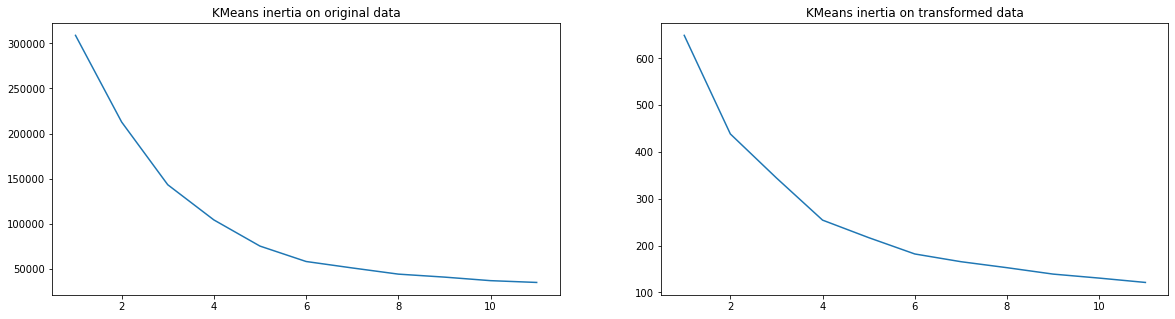

In [13]:
# untransformed data
inertia = []
for i in range(1, 12):
    km = KMeans(n_clusters=i).fit(df)
    inertia.append(km.inertia_)

# transformed data
inertia_t = []
for i in range(1, 12):
    km = KMeans(n_clusters=i).fit(df_t)
    inertia_t.append(km.inertia_)

# plot results
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.lineplot(x=range(1,12), y=inertia)
plt.title('KMeans inertia on original data')

plt.subplot(1,2,2)
sns.lineplot(x=range(1,12), y=inertia_t)
plt.title('KMeans inertia on transformed data')

plt.show()

## Elbow results
When looking on inertia for original data, 2, 3 and 5 seems to be our candidates for number of clusters. When looking on inertia in transformed data, 2 and 4 seems to be best... so we simply check how clustering looks like when using 2, 3, 4 and 5 clusters. 

In [14]:
# collect cluster labels as well as cluster centers
clusters = [2,3,4,5]
cluster_centers = {}

for c in clusters:
    km = KMeans(n_clusters=c).fit(df[['Age', 'Income', 'Score', 'Gender']])
    df['cluster' + str(c)] = km.labels_
    cluster_centers[str(c)] = km.cluster_centers_

# Select best cluster number
Now, we will draw 4 charts showing clustering on chart income vs spending. Cluster centers are drawn as well. Based on business needs, we should choose one that we can describe bests and will be useful for our business.

From my point of view, KMeans outperforms other when number of clusters is 2 or 5.

I think 2 is not enough clusters and just divide customers into 2 groups - score under 50 and score over 50 so does not look well.

On the other side, when using 5 clusters, we are getting 5 different groups of customers that separates well from each other and we could run different campaigns on each customer group!

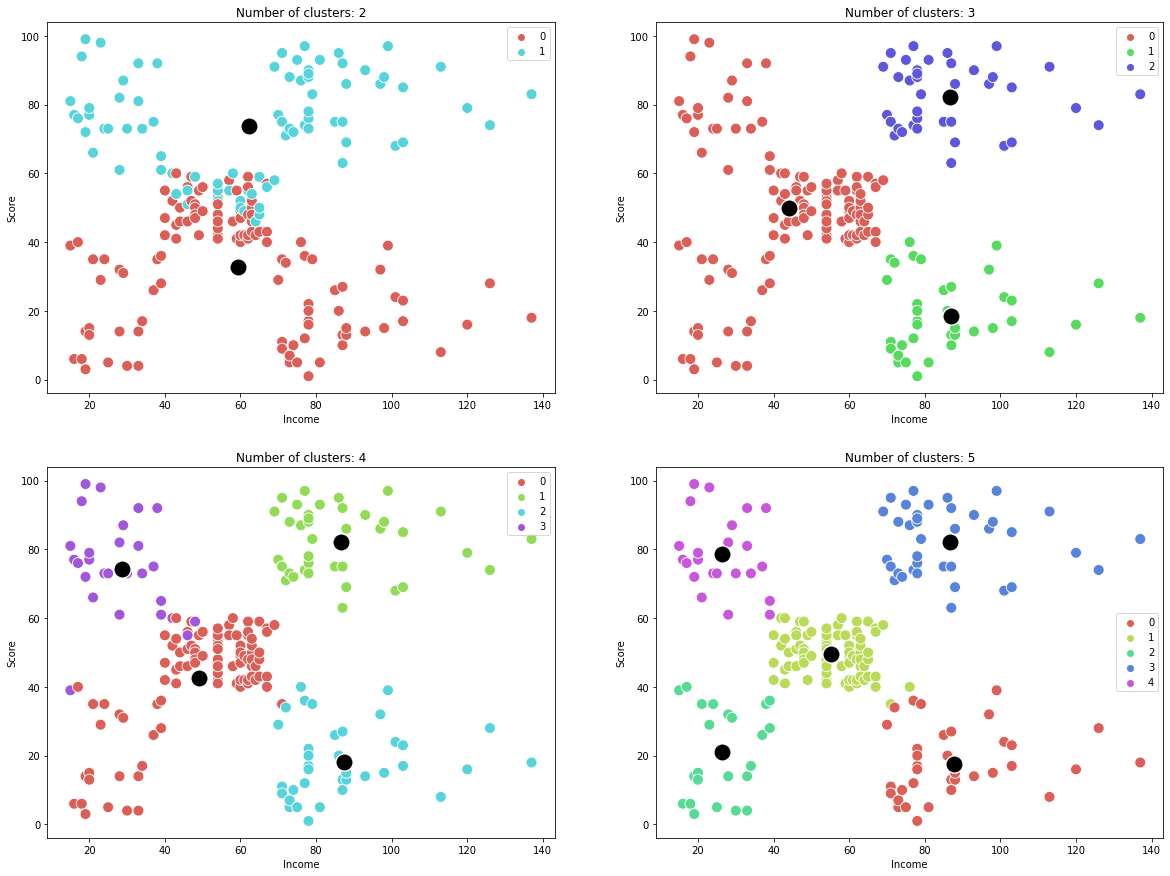

In [15]:
plt.figure(figsize=(20,15))
for i, c in enumerate(clusters):
    plt.subplot(2,2,i+1)
    sns.scatterplot(df.Income, df.Score, df['cluster' + str(c)], s=120, palette=sns.color_palette("hls", c))
    sns.scatterplot(cluster_centers[str(c)][:,1], cluster_centers[str(c)][:,2], color='black', s=300)
    plt.title('Number of clusters: ' + str(c))
    
plt.show()

### Draw winning clustering

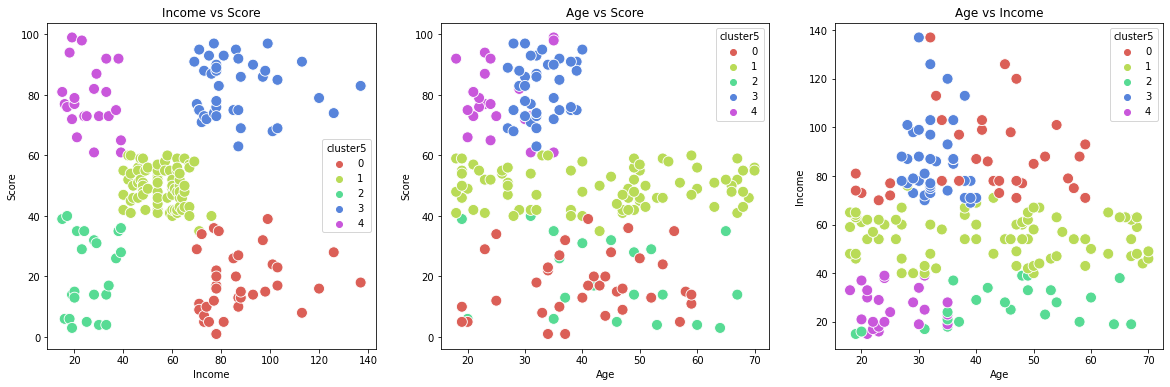

In [16]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.scatterplot(df.Income, df.Score, df['cluster5'], s=120, palette=sns.color_palette("hls", 5))
plt.title('Income vs Score')
   
plt.subplot(1,3,2)
sns.scatterplot(df.Age, df.Score, df['cluster5'], s=120, palette=sns.color_palette("hls", 5))
plt.title('Age vs Score')

plt.subplot(1,3,3)
sns.scatterplot(df.Age, df.Income, df['cluster5'], s=120, palette=sns.color_palette("hls", 5))
plt.title('Age vs Income')

plt.show()

# Conclusion
We have selected to have 5 clusters, meaning 5 customer groups. But who are people in these groups? Let's try to describe them for marketing team!

- **Poor and not-spender** - customers with low income and low spending score (cluster #4)
- **Poor and spender** - customers with low income, but spending a lot (cluster #1)
- **Neutral** - customers with mid income and mid spending score (cluster #0)
- **Rich and not-spender** - customers with high income and low spending score (cluster #2)
- **Rich and spender** - customers with high income and high spending score (cluster #3)